In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_f1_score
from sklearn_crfsuite.metrics import flat_classification_report

## Reading Extracted Genia File

In [2]:
#Reading the csv file
df = pd.read_csv('Genia_all.csv', encoding = "ISO-8859-1",index_col=None)
df.drop(columns=['Chunk_Tag'], inplace=True)

In [3]:
#Display first 10 rows
df.head(5)

,Sent,Tok,POS_Tag,NE_Tag
0,1,IL-2,JJ,B-DNA
1,1,gene,NN,I-DNA
2,1,expression,NN,O
3,1,and,CC,O
4,1,NF-kappa,NNP,B-protein


## Summary of Data

In [4]:
df.describe()

,Sent
count,593590.000000
mean,11194.130081
std,6461.062798
min,1.000000
25%,5569.000000
50%,11186.000000
75%,16812.000000
max,22402.000000


In [5]:
#Displaying the unique Tags
df['NE_Tag'].unique()
#To select rows whose column value without '0':
#df=df.loc[df['NE_Tag'] != 'O']
#df.describe()

array(['B-DNA', 'I-DNA', 'O', 'B-protein', 'I-protein', 'B-cell_type',
       'I-cell_type', 'B-cell_line', 'I-cell_line', 'B-RNA', 'I-RNA'],
      dtype=object)

In [6]:
#Displaying the unique Tags
df['NE_Tag'].unique()

array(['B-DNA', 'I-DNA', 'O', 'B-protein', 'I-protein', 'B-cell_type',
       'I-cell_type', 'B-cell_line', 'I-cell_line', 'B-RNA', 'I-RNA'],
      dtype=object)

## Checking if there are any null values

In [7]:
#Checking null values, if any.
df.isnull().sum()

 Sent       0
Tok        16
POS_Tag     0
NE_Tag      0
dtype: int64

## Eliminating null values from the dataframe

In [8]:
df = df.fillna(method = 'ffill')

In [9]:
# This is a class te get sentence. The each sentence will be list of tuples with its tag and pos.
class sentence(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, p, t) for w, p, t in zip(s['Tok'].values.tolist(),
                                                       s['POS_Tag'].values.tolist(),
                                                       s['NE_Tag'].values.tolist())]
        self.grouped = self.df.groupby(" Sent").apply(agg)
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

## Getting sentences with their POS tag and NE Tag

In [10]:
#Displaying one full sentence
getter = sentence(df)
sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences[1]

'Activation of the CD28 surface receptor provides a major costimulatory signal for T cell activation resulting in enhanced production of interleukin-2 ( IL-2 ) and cell proliferation .'

In [11]:
#sentence with its pos and tag.
sent = getter.sentences
sentences = getter.sentences
sentences[18545]

[('The', 'DT', 'O'),
 ('aberrant', 'JJ', 'O'),
 ('activation', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('AP-1', 'NNP', 'B-protein'),
 ('by', 'IN', 'O'),
 ('gp160', 'NN', 'B-protein'),
 ('in', 'IN', 'O'),
 ('CD4', 'NNP', 'B-cell_type'),
 ('positive', 'JJ', 'I-cell_type'),
 ('T', 'NNP', 'I-cell_type'),
 ('cells', 'NNS', 'I-cell_type'),
 ('could', 'MD', 'O'),
 ('result', 'VB', 'O'),
 ('in', 'IN', 'O'),
 ('up-regulation', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('cytokines', 'NNS', 'B-protein'),
 ('containing', 'VBG', 'O'),
 ('AP-1', 'NNP', 'B-DNA'),
 ('sites', 'NNS', 'I-DNA'),
 (',', ',', 'O'),
 ('e.g', 'NN', 'O'),
 ('.', '.', 'O'),
 ('interleukin-3', 'JJ', 'B-protein'),
 ('and', 'CC', 'O'),
 ('granulocyte', 'JJ', 'B-protein'),
 ('macrophage', 'NN', 'I-protein'),
 ('colony-stimulating', 'JJ', 'I-protein'),
 ('factor', 'NN', 'I-protein'),
 (',', ',', 'O'),
 ('and', 'CC', 'O'),
 ('concurrently', 'RB', 'O'),
 ('lead', 'VBP', 'O'),
 ('to', 'TO', 'O'),
 ('T', 'NNP', 'B-cell_type'),
 ('cell', 'NN', 'I-cell_t

## Extracting Features 

In [12]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

# creating dictionary
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

## Splitting sentences and labels into x and y

In [13]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]
tok=[sent2tokens(s) for s in sentences]
len(X)

22402

In [14]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(X[18546])
print(y[0])

[{'bias': 1.0, 'word.lower()': 'number', 'word[-3:]': 'ber', 'word[-2:]': 'er', 'word.isupper()': False, 'word.istitle()': True, 'word.isdigit()': False, 'postag': 'NNP', 'postag[:2]': 'NN', 'BOS': True, '+1:word.lower()': 'of', '+1:word.istitle()': False, '+1:word.isupper()': False, '+1:postag': 'IN', '+1:postag[:2]': 'IN'}, {'bias': 1.0, 'word.lower()': 'of', 'word[-3:]': 'of', 'word[-2:]': 'of', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, 'postag': 'IN', 'postag[:2]': 'IN', '-1:word.lower()': 'number', '-1:word.istitle()': True, '-1:word.isupper()': False, '-1:postag': 'NNP', '-1:postag[:2]': 'NN', '+1:word.lower()': 'glucocorticoid', '+1:word.istitle()': False, '+1:word.isupper()': False, '+1:postag': 'JJ', '+1:postag[:2]': 'JJ'}, {'bias': 1.0, 'word.lower()': 'glucocorticoid', 'word[-3:]': 'oid', 'word[-2:]': 'id', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, 'postag': 'JJ', 'postag[:2]': 'JJ', '-1:word.lower()': 'of', '

## Splitting data into training and test set and extracting actual tokens for comparison of test prediction

In [15]:
X_train=X[0:18546]
X_test=X[18546:22402]
y_train=y[0:18546]
y_test=y[18546:22402]
tok_test=tok[18546:22402]


## Training CRF Model

In [16]:
crf = CRF(algorithm = 'lbfgs',
         c1 = 0.1,
         c2 = 0.1,
         max_iterations = 100,
         all_possible_transitions = False)
crf.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=False,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

## Predicting on the test set.

In [17]:
y_pred = crf.predict(X_test)

## Evaluating Model performance

In [18]:
f1_score = flat_f1_score(y_test, y_pred, average = 'weighted')
print(f1_score)

0.9209146539943036


In [19]:
report = flat_classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       B-DNA       0.68      0.66      0.67      1056
       B-RNA       0.63      0.65      0.64       118
 B-cell_line       0.59      0.60      0.59       500
 B-cell_type       0.80      0.68      0.73      1921
   B-protein       0.72      0.79      0.76      5067
       I-DNA       0.72      0.75      0.74      1789
       I-RNA       0.74      0.70      0.72       187
 I-cell_line       0.62      0.70      0.66       989
 I-cell_type       0.86      0.73      0.79      2991
   I-protein       0.75      0.73      0.74      4774
           O       0.96      0.97      0.96     81647

    accuracy                           0.92    101039
   macro avg       0.73      0.72      0.73    101039
weighted avg       0.92      0.92      0.92    101039



In [20]:
from sklearn.externals import joblib
joblib.dump(crf, 'NER_CRF_model.pkl')

/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['NER_CRF_model.pkl']

## Checking Classification model performance in different classes of NE_Tag

In [96]:
import eli5
eli5.show_weights(crf, top=30)

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


From \ To,O,B-DNA,I-DNA,B-RNA,I-RNA,B-cell_line,I-cell_line,B-cell_type,I-cell_type,B-protein,I-protein
O,4.633,2.001,0.0,2.161,0.0,2.162,0.0,2.112,0.0,2.417,0.0
B-DNA,-0.464,-2.623,7.063,-1.605,0.0,0.0,0.0,0.0,0.0,-3.276,0.0
I-DNA,-1.052,-1.874,7.202,0.0,0.0,0.0,0.0,0.0,0.0,-3.871,0.0
B-RNA,-1.547,-1.047,0.0,0.0,8.349,0.0,0.0,0.0,0.0,0.0,0.0
I-RNA,-1.664,0.0,0.0,0.0,8.106,0.0,0.0,0.0,0.0,0.0,0.0
B-cell_line,-0.611,0.0,0.0,0.0,0.0,0.0,7.121,-2.31,0.0,-2.392,0.0
I-cell_line,-0.798,0.0,0.0,-0.652,0.0,-0.986,7.505,-2.071,0.0,-2.41,0.0
B-cell_type,-0.625,0.0,0.0,0.0,0.0,0.0,0.0,-2.279,6.927,-2.099,0.0
I-cell_type,-1.478,-2.39,0.0,0.0,0.0,-2.094,0.0,-4.098,6.649,-2.817,0.0
B-protein,1.124,-1.558,0.0,-1.313,0.0,-1.661,0.0,-2.078,0.0,-0.701,7.05


## Tunning the model

In [97]:
crf = CRF(algorithm = 'lbfgs',
         c1 = 10,
         c2 = 0.1,
         max_iterations = 100,
         all_possible_transitions = False)
crf.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=False,
    averaging=None, c=None, c1=10, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [98]:
#Predicting on the test set.
y_pred = crf.predict(X_test)

In [99]:
f1_score = flat_f1_score(y_test, y_pred, average = 'weighted')
print(f1_score)

0.9082545946852902


In [100]:
report = flat_classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       B-DNA       0.68      0.61      0.64      1056
       B-RNA       0.66      0.68      0.67       118
 B-cell_line       0.54      0.52      0.53       500
 B-cell_type       0.79      0.60      0.68      1921
   B-protein       0.69      0.71      0.70      5067
       I-DNA       0.68      0.75      0.71      1789
       I-RNA       0.69      0.71      0.70       187
 I-cell_line       0.57      0.68      0.62       989
 I-cell_type       0.84      0.69      0.76      2991
   I-protein       0.74      0.67      0.70      4774
           O       0.95      0.96      0.96     81647

    accuracy                           0.91    101039
   macro avg       0.71      0.69      0.70    101039
weighted avg       0.91      0.91      0.91    101039



In [101]:
import eli5
eli5.show_weights(crf, top=30)

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


From \ To,O,B-DNA,I-DNA,B-RNA,I-RNA,B-cell_line,I-cell_line,B-cell_type,I-cell_type,B-protein,I-protein
O,4.18,2.662,0.0,2.575,0.0,3.474,0.0,3.245,0.0,2.988,0.0
B-DNA,0.571,-0.063,7.71,0.0,0.0,0.0,0.0,0.0,0.0,-0.646,0.0
I-DNA,-0.855,-0.505,6.691,0.0,0.0,0.0,0.0,0.0,0.0,-2.333,0.0
B-RNA,-1.773,0.0,0.0,0.0,7.266,0.0,0.0,0.0,0.0,0.0,0.0
I-RNA,-0.842,0.0,0.0,0.0,7.507,0.0,0.0,0.0,0.0,0.0,0.0
B-cell_line,-0.758,0.0,0.0,0.0,0.0,0.0,7.2,0.0,0.0,-1.108,0.0
I-cell_line,-0.802,0.0,0.0,0.0,0.0,0.673,7.73,0.0,0.0,-2.067,0.0
B-cell_type,-0.286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.8,-1.283,0.0
I-cell_type,-0.507,-0.273,0.0,0.0,0.0,0.0,0.0,-0.017,7.119,-1.064,0.0
B-protein,1.05,-0.694,0.0,0.0,0.0,0.0,0.0,-1.102,0.0,0.294,6.673


## Comparing predicted labels and actual labels of the tokens

In [102]:
import numpy as np
x=np.array([np.array(xi) for xi in y_pred])
type(x)
x = np.hstack(x)
x1=pd.DataFrame({'prediction':x})
x1.head()

,prediction
0,O
1,O
2,B-protein
3,I-protein
4,O


In [103]:
import numpy as np
Y=np.array([np.array(xi) for xi in y_test])
type(Y)
Y = np.hstack(Y)
y1=pd.DataFrame({'true':Y})
y1.head()

,true
0,O
1,O
2,B-protein
3,I-protein
4,O


In [104]:
import numpy as np
word=np.array([np.array(xi) for xi in tok_test])
type(word)
word = np.hstack(word)
word1=pd.DataFrame({'word':word})
word1.head()

,word
0,Number
1,of
2,glucocorticoid
3,receptors
4,in


In [105]:

# Place the DataFrames side by side
stack = pd.concat([word1, x1], axis=1)
pred=pd.concat([stack, y1], axis=1)
pred.shape

(101039, 3)

## Creating file containing missclassified labels

In [106]:
export_csv = pred.to_csv (r'Genia_pred.csv', index = None, header=True)

In [107]:
missclass=pred.loc[~(pred['prediction'] == pred['true'])]

In [108]:
export_csv = missclass.to_csv (r'Genia_errors.csv', index = None, header=True)

In [109]:
df = pd.read_csv("Genia_errors.csv")

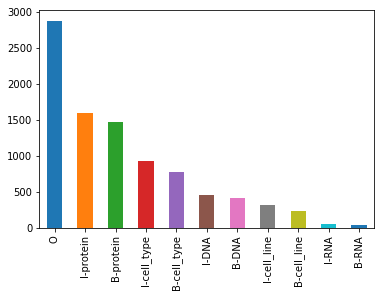

In [111]:
df['true'].value_counts().plot('bar')

## Random Evaluation of 65 Sentences

In [159]:
df = pd.read_csv("Genia_test.csv")
#Displaying the unique Tags
df.head()

,Sent,Tok,POS_Tag,Chunk_Tag,NE_Tag
0,18550,On,IN,O,O
1,18550,the,DT,O,O
2,18550,other,JJ,B-NBAR,O
3,18550,hand,NN,I-NBAR,O
4,18550,",",",",O,O


In [160]:

#Displaying the unique Tags
df['NE_Tag'].unique()

array(['O', 'B-protein', 'B-cell_type', 'I-protein', 'I-cell_type',
       'B-DNA', 'I-DNA', 'B-cell_line', 'I-cell_line'], dtype=object)

In [161]:
#Checking null values, if any.
df.isnull().sum()

 Sent        0
Tok          0
POS_Tag      0
Chunk_Tag    0
NE_Tag       0
dtype: int64

In [162]:
# This is a class te get sentence. The each sentence will be list of tuples with its tag and pos.
class sentence(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, p, t) for w, p, t in zip(s['Tok'].values.tolist(),
                                                       s['POS_Tag'].values.tolist(),
                                                       s['NE_Tag'].values.tolist())]
        self.grouped = self.df.groupby(" Sent").apply(agg)
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

In [163]:
#Displaying one full sentence
getter = sentence(df)
sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences[0]
with open('test.txt', 'w') as filehandle:
    for listitem in sentences:
        filehandle.write('%s\n' % listitem)

In [165]:
#sentence with its pos and tag.
sent = getter.sentences
sentences = getter.sentences
len(sentences)
print(sentences[59])
print(len(sentences))

[('To', 'TO', 'O'), ('further', 'RBR', 'O'), ('characterize', 'VB', 'O'), ('the', 'DT', 'O'), ('consequences', 'NNS', 'O'), ('of', 'IN', 'O'), ('this', 'DT', 'O'), ('biased', 'VBN', 'O'), ('co-stimulatory', 'NN', 'O'), ('dependency', 'NN', 'O'), (',', ',', 'O'), ('we', 'PRP', 'O'), ('employed', 'VBD', 'O'), ('a', 'DT', 'O'), ('well-defined', 'JJ', 'O'), ('system', 'NN', 'O'), ('of', 'IN', 'O'), ('transfected', 'JJ', 'O'), ('CHO', 'NNP', 'B-cell_line'), ('cells', 'NNS', 'I-cell_line'), ('expressing', 'VBG', 'O'), ('human', 'JJ', 'B-protein'), ('MHC', 'NNP', 'I-protein'), ('class', 'NN', 'I-protein'), ('II', 'NNP', 'I-protein'), ('together', 'RB', 'O'), ('with', 'IN', 'O'), ('CD80', 'NNP', 'B-protein'), (',', ',', 'O'), ('CD86', 'NNP', 'B-protein'), ('or', 'CC', 'O'), ('CD80', 'NNP', 'B-protein'), ('and', 'CC', 'O'), ('CD86', 'NNP', 'B-protein'), ('.', '.', 'O')]
60


In [166]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

# creating dictionary
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [167]:
X_eval = [sent2features(s) for s in sentences]
y_eval = [sent2labels(s) for s in sentences]
tok_eval=[sent2tokens(s) for s in sentences]
len(tok_eval)

60

In [168]:
eval_pred = crf.predict(X_eval)
report = flat_classification_report(y_eval, eval_pred)
print(report)


x=np.array([np.array(xi) for xi in eval_pred])
type(x)
x = np.hstack(x)
eval1=pd.DataFrame({'prediction':x})


Y=np.array([np.array(xi) for xi in y_eval])
type(Y)
Y = np.hstack(Y)
true1=pd.DataFrame({'true':Y})


word=np.array([np.array(xi) for xi in tok_eval])
type(word)
word = np.hstack(word)
tok1=pd.DataFrame({'word':word})

# Place the DataFrames side by side
stack = pd.concat([tok1, eval1], axis=1)
pred=pd.concat([stack, true1], axis=1)



              precision    recall  f1-score   support

       B-DNA       0.66      0.84      0.74        25
 B-cell_line       0.50      0.42      0.45        12
 B-cell_type       0.83      0.50      0.62        20
   B-protein       0.73      0.61      0.66        71
       I-DNA       0.68      0.82      0.74        60
 I-cell_line       0.61      0.65      0.63        17
 I-cell_type       0.67      0.40      0.50        20
   I-protein       0.77      0.66      0.71        74
           O       0.96      0.97      0.96      1388

    accuracy                           0.92      1687
   macro avg       0.71      0.65      0.67      1687
weighted avg       0.91      0.92      0.91      1687



In [169]:
missclass_eval=pred.loc[~(pred['prediction'] == pred['true'])]
export_csv = missclass_eval.to_csv (r'error_comp.csv', index = None, header=True)

In [170]:
export_csv = pred.to_csv (r'predictions.csv', index = None, header=True)

In [171]:
eli5.show_weights(crf, top=30)

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


From \ To,O,B-DNA,I-DNA,B-RNA,I-RNA,B-cell_line,I-cell_line,B-cell_type,I-cell_type,B-protein,I-protein
O,4.18,2.662,0.0,2.575,0.0,3.474,0.0,3.245,0.0,2.988,0.0
B-DNA,0.571,-0.063,7.71,0.0,0.0,0.0,0.0,0.0,0.0,-0.646,0.0
I-DNA,-0.855,-0.505,6.691,0.0,0.0,0.0,0.0,0.0,0.0,-2.333,0.0
B-RNA,-1.773,0.0,0.0,0.0,7.266,0.0,0.0,0.0,0.0,0.0,0.0
I-RNA,-0.842,0.0,0.0,0.0,7.507,0.0,0.0,0.0,0.0,0.0,0.0
B-cell_line,-0.758,0.0,0.0,0.0,0.0,0.0,7.2,0.0,0.0,-1.108,0.0
I-cell_line,-0.802,0.0,0.0,0.0,0.0,0.673,7.73,0.0,0.0,-2.067,0.0
B-cell_type,-0.286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.8,-1.283,0.0
I-cell_type,-0.507,-0.273,0.0,0.0,0.0,0.0,0.0,-0.017,7.119,-1.064,0.0
B-protein,1.05,-0.694,0.0,0.0,0.0,0.0,0.0,-1.102,0.0,0.294,6.673


In [172]:
df = pd.read_csv("error_comp.csv")
df.head()

,word,prediction,true
0,1,O,B-protein
1,",",O,I-protein
2,25-Dihydroxyvitamin,B-protein,I-protein
3,T-,B-protein,B-cell_type
4,and,O,I-cell_type


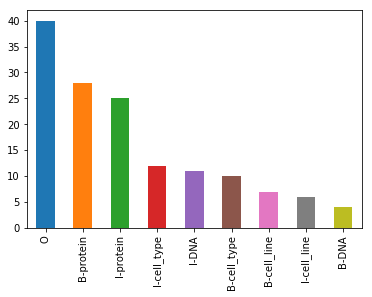

In [173]:
df['true'].value_counts().plot('bar')